In [1]:
import torch.cuda
import sys

sys.path.append('..')

from src.henry.mnist_vae_pure import VariationalAutoencoder
import torchvision
import torchvision.datasets as datasets
import pickle
from matplotlib import pyplot as plt
import numpy as np
from utils import * 
from WeightsModification import * 
from federated_pure import federate




In [2]:
# I generated images on 4237987
class FakeArgs:
    def __init__(self):
        self.seed = None # We don't want a seed if we're doing multiple trials
        self.epochs = 25
        self.dataset = "mnist"
        self.num_users=10
        self.iid = 2
        self.dirichlet = 0.5 
        self.local_ep=10
        self.local_bs=64
        self.beta=1.0
    # def __init__(self):
    #     self.epochs = 25
    #     self.dataset = "fmnist"
    #     self.num_users=10
    #     self.iid = 2
    #     self.dirichlet = 0.5 
    #     self.local_ep=10
    #     self.local_bs=64
    #     self.beta=1.0
        

In [3]:

def run_trial_iteration(runtime_args):
    alpha_values = [0.1,0.5,0.9]
    vae_beta_values = [1.0,10.0]

    for vae_beta_val in vae_beta_values:
        runtime_args.beta=vae_beta_val
        
        baseline_result = federate(runtime_args)
        baseline_result.serialise("baseline", runtime_args)
        
        for alpha in alpha_values:
            try:
                new_weights = calculate_new_weights(baseline_result.global_model.encoder, baseline_result.client_datasets, alpha,0.0)
                second_res = federate(runtime_args,new_weights, baseline_result.client_datasets)
                second_res.serialise("alpha_" + str(alpha),runtime_args)
            except HyperValueError as e:
                # We simply ignore the case 
                pass
        




In [ ]:
def run_trial():
    start_args = FakeArgs()
    run_trial_iteration(start_args)
    
    # fmnist
    start_args.dataset = "fmnist"
    run_trial_iteration(start_args)
    
    ## NIID ~ 2
    start_args.dataset = "mnist"
    start_args.iid = 4
    start_args.num_users = 6
    run_trial_iteration(start_args)
    
    start_args.dataset = "fmnist"
    run_trial_iteration(start_args)
    
run_trial()
    

/home/henry/anaconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 659.603984485973
Finished local epoch 2 out of 10, average loss across batches: 595.2489901455966
Finished local epoch 3 out of 10, average loss across batches: 575.1381086869674
Finished local epoch 4 out of 10, average loss across batches: 561.826943137429
Finished local epoch 5 out of 10, average loss across batches: 556.6339305530895
Finished local epoch 6 out of 10, average loss across batches: 551.5357763117009
Finished local epoch 7 out of 10, average loss across batches: 547.6302975741299
Finished local epoch 8 out of 10, average loss across batches: 543.59340875799
Finished local epoch 9 out of 10, average loss across batches: 541.2523803710938
Finished local epoch 10 out of 10, average loss across batches: 538.6607041792436
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 631.2273495061611
Finished local epoch 2 ou

In [3]:
# vae, ovr_losses, mse_losses, kl_losses = vae.train_model(dataset_train,16,10)
# print(mse_losses)
# print(kl_losses)
# 46 -> 34
res = federate(FakeArgs())
res.serialise("BOGUS_TEST",FakeArgs())





/home/henry/anaconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
0it [00:00, ?it/s]

TRAINING ALL DONE!


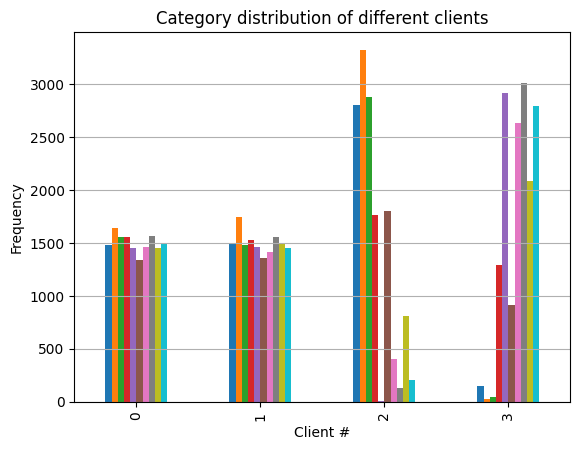

In [4]:
ClientDatasetManager.plot_dataset_splits(res.client_datasets)


In [7]:
res.global_model = res.global_model.to('cuda')

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to('cuda')
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [ ]:
plot_reconstructed(res.global_model, r0=(-3, 3), r1=(-3, 3))


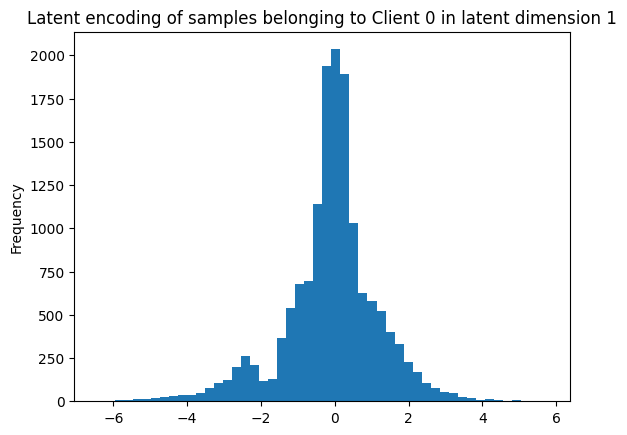

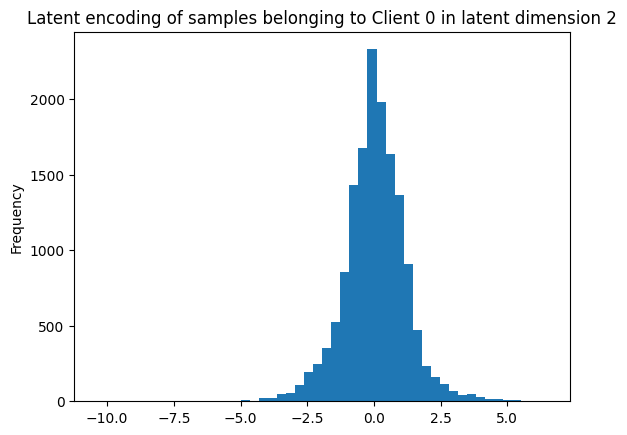

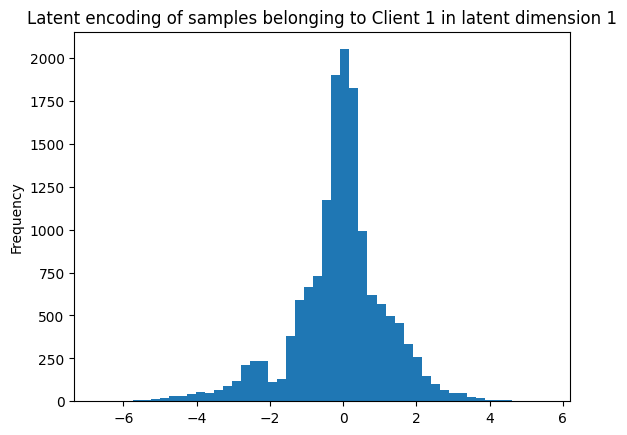

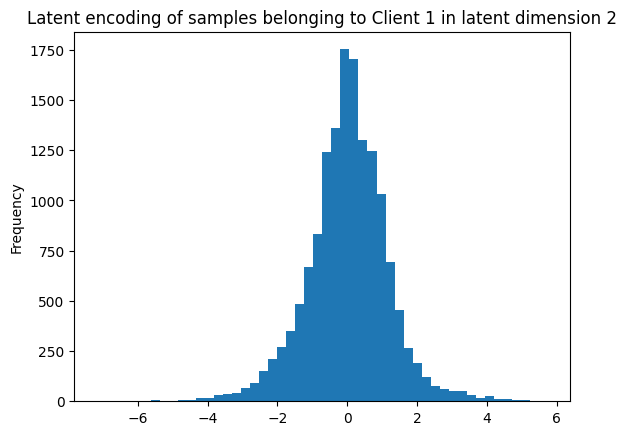

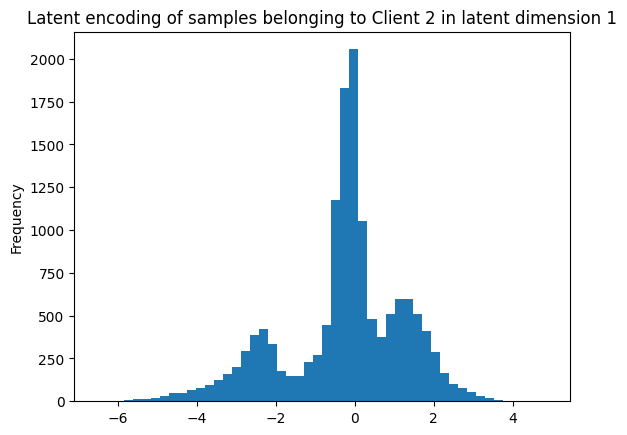

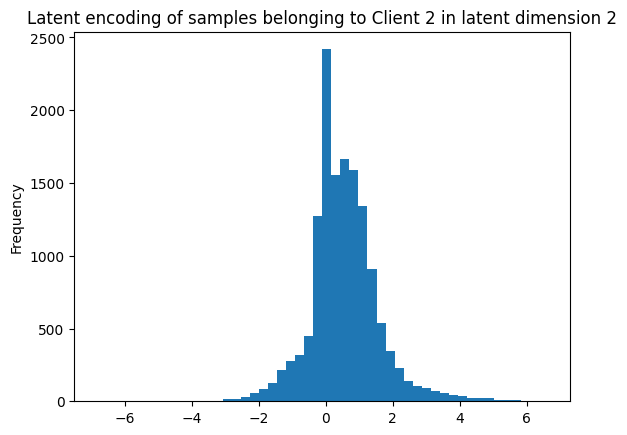

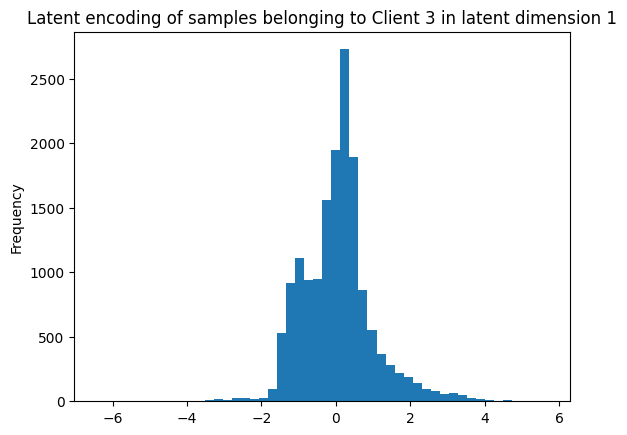

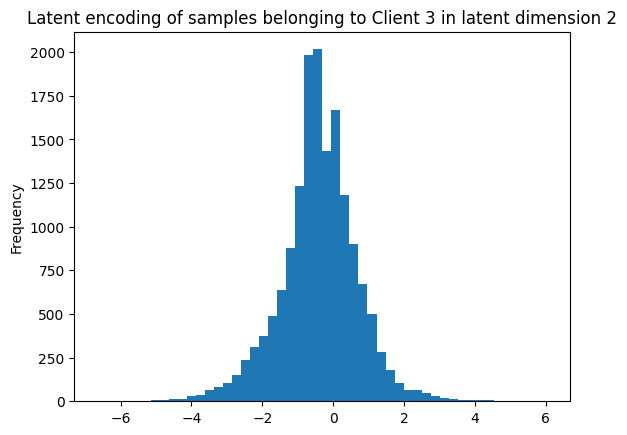

In [6]:
trial_weights = calculate_new_weights(res.global_model.encoder, res.client_datasets,0.5,0.0)


In [8]:
print(f"Original Weights: {calculate_relative_dataset_sizes(res.client_datasets)}")
print(f"New Weights: {trial_weights}")

Original Weights: [0.25000833361112035, 0.25000833361112035, 0.23532451081702724, 0.26465882196073204]
New Weights: [0.37006298828821843, 0.37561911293143474, 0.0008803248467934863, 0.2534375739335534]


In [ ]:
second_res = federate(FakeArgs(), trial_weights, res.client_datasets)
second_res.serialise("bogus_point_one",FakeArgs())


In [ ]:
a = res.global_loss_manager.validation_total_across_communication

In [ ]:
b = second_res.global_loss_manager.validation_total_across_communication

In [ ]:
list(zip(a,b))